<div class="alert alert-block alert-success">

## <center> Part II </center>
## <center> ElasticSearch index and vector embeddings</center>
    

</div>

<hr style="border:1px solid black"> </hr>
<div class="alert alert-info">   
    
## REQUIREMENT 1
Create a Bar Chart to plot the number of issues created for every repository for every day of the week; that is total number of issues created on Monday, Tuesday, Wednesday …, Sunday for EVERY Repo name.
    
</div>

C:\Users\soham\AppData\Local\Temp\ipykernel_7176\1115107872.py:10: DtypeWarning: Columns (5,6,7,8,9,10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_detailed = pd.read_csv("github_all_data.csv")
C:\Users\soham\AppData\Local\Temp\ipykernel_7176\1115107872.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_issues['created_at'] = pd.to_datetime(df_issues['created_at'])
C:\Users\soham\AppData\Local\Temp\ipykernel_7176\1115107872.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

<Figure size 1200x600 with 0 Axes>

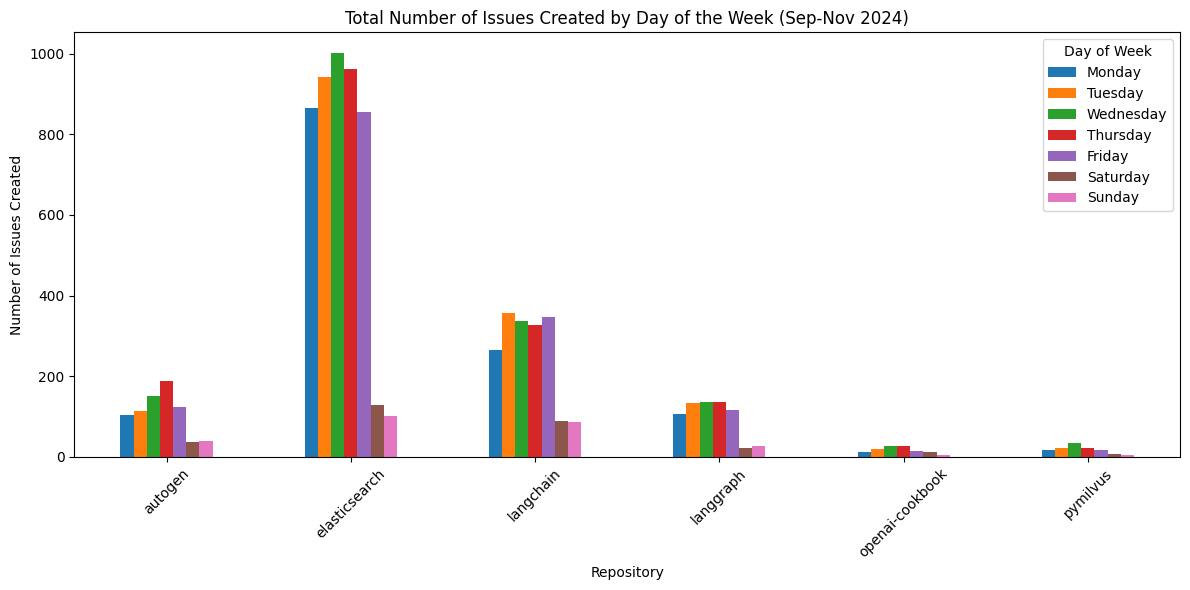

In [2]:
'''
Name: Soham Sonar
CWID:A20541266
'''

import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df_detailed = pd.read_csv("github_all_data.csv")

# Filter for the issues created
df_issues = df_detailed[df_detailed['type'] == 'issue']

# Convert 'created_at' to datetime format
df_issues['created_at'] = pd.to_datetime(df_issues['created_at'])

# Filter for the date range (September 2024 to November 2024)
start_date = "2024-09-01"
end_date = "2024-11-30"
df_issues_filtered = df_issues[(df_issues['created_at'] >= start_date) & (df_issues['created_at'] <= end_date)]

# Extract the day of the week from the 'created_at' column
df_issues_filtered['day_of_week'] = df_issues_filtered['created_at'].dt.day_name()

# Group by repository and day of the week, then count the number of issues
issue_counts = df_issues_filtered.groupby(['repository', 'day_of_week']).size().unstack(fill_value=0)

# Reorder the days of the week
days_of_week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
issue_counts = issue_counts[days_of_week_order]

# Plot the bar chart
plt.figure(figsize=(12, 6))
issue_counts.plot(kind='bar', stacked=False, figsize=(12, 6))

# Customize the plot
plt.title('Total Number of Issues Created by Day of the Week (Sep-Nov 2024)')
plt.xlabel('Repository')
plt.ylabel('Number of Issues Created')
plt.xticks(rotation=45)
plt.legend(title='Day of Week')
plt.tight_layout()

# Show the plot
plt.show()



<hr style="border:1px solid black"> </hr>
<div class="alert alert-info">   
    
## REQUIREMENT 2
Use vector embeddings, score, and semantic search to identify and list the Top 5 most similar issues for every repo listed above.
    
</div>

In [10]:
import requests
from datetime import datetime, timedelta
from elasticsearch import Elasticsearch

es = Elasticsearch(['http://localhost:9200'])
es.ping()   #connection testing

True

In [11]:
# To search documents 

#Import Elasticsearch and helpers from  elasticsearch

from elasticsearch import Elasticsearch,helpers
import json

es = Elasticsearch(['http://localhost:9200'])
es.ping()   #connection testing
res = es.search(index="github_issues", body={"query": {"match_all": {}}})

# Extract the total hit count
print("Got %d Hits:" % res['hits']['total']['value'])

# Extract hits from the response
hits = res.get('hits', {})

# Pretty print the hits
print(json.dumps(hits, indent=2))

Got 3911 Hits:
{
  "total": {
    "value": 3911,
    "relation": "eq"
  },
  "max_score": 1.0,
  "hits": [
    {
      "_index": "github_issues",
      "_id": "AmLQUZMBKaR7I-arfsTA",
      "_score": 1.0,
      "_source": {
        "_type": "issue",
        "_repo": "langchain",
        "_issueNumber": "28276",
        "_title": "langchain-chroma== 0.1.4   method get_by_ids is listed in documentation BUT I am getting NotImplementedError",
        "_createdAt": "2024-11-22T01:13:50Z",
        "_closedAt": "2024-12-31T00:36:30Z",
        "_state": "open",
        "_body": "### Checked other resources\n\n- [X] I added a very descriptive title to this issue.\n- [X] I searched the LangChain documentation with the integrated search.\n- [X] I used the GitHub search to find a similar question and didn't find it.\n- [X] I am sure that this is a bug in LangChain rather than my code.\n- [X] The bug is not resolved by updating to the latest stable version of LangChain (or the specific integration p

In [18]:
from elasticsearch import Elasticsearch
import json

# Initialize Elasticsearch client
es = Elasticsearch(['http://localhost:9200'])

# List of repositories
repositories = [
    ("openai", "openai-cookbook"),
    ("elastic", "elasticsearch"),
    ("langchain-ai", "langchain"),
    ("milvus-io", "pymilvus"),
    ("langchain-ai", "langgraph"),
    ("microsoft", "autogen")
]

# Function to perform semantic search and retrieve top similar issues
def semantic_search(issue_vector, k=5):
    response = es.search(
        index="github_issues",
        knn={
            "field": "GitHub_Issue_vector",
            "query_vector": issue_vector,
            "k": k,
            "num_candidates": 10000
        }
    )

    similar_issues = []
    for hit in response["hits"]["hits"]:
        similar_issue = {
            "_score": hit["_score"],
            "_type": hit["_source"]["_type"],
            "_repo": hit["_source"]["_repo"],
            "_issueNumber": hit["_source"]["_issueNumber"],
            "_title": hit["_source"]["_title"],
            "_createdAt": hit["_source"]["_createdAt"],
            "_closedAt": hit["_source"]["_closedAt"],
            "_body": hit["_source"]["_body"]
        }
        similar_issues.append(similar_issue)

    return similar_issues

# Iterate through repositories
print("\n" + "-" * 75 + "\n")
for owner, repo in repositories:
    
    print(f"Top 5 similar issues for {owner}/{repo}:")
    print("\n" + "-" * 75 + "\n")
    
    # Fetch recent issues for the current repository
    res = es.search(index="github_issues", body={"query": {"match": {"_repo": f"{owner}/{repo}"}}})
    hits = res.get('hits', {})
    
    # Choose an issue from the repository's recent issues
    chosen_issue = hits['hits'][0]['_source'] if hits['hits'] else None
    
    if chosen_issue:
        issue_vector = chosen_issue.get("GitHub_Issue_vector")
        similar_issues = semantic_search(issue_vector, k=5)

        # Output similar issues
        for similar_issue in similar_issues:
            print(json.dumps(similar_issue, indent=2))
    else:
        print(f"No recent similar issues from last 2 months found for {owner}/{repo}")
    
    print("\n" + "-" * 75 + "\n")



---------------------------------------------------------------------------

Top 5 similar issues for openai/openai-cookbook:

---------------------------------------------------------------------------

No recent similar issues from last 2 months found for openai/openai-cookbook

---------------------------------------------------------------------------

Top 5 similar issues for elastic/elasticsearch:

---------------------------------------------------------------------------

{
  "_score": 1.0,
  "_type": "issue",
  "_repo": "elasticsearch",
  "_issueNumber": "116131",
  "_title": "[8.16] Resolve pipelines from template if lazy rollover write  (#116031)",
  "_createdAt": "2024-11-02T03:56:02Z",
  "_closedAt": "2024-11-02T17:12:07Z",
  "_body": "Backports the following commits to 8.16:\n - Resolve pipelines from template if lazy rollover write  (#116031)"
}
{
  "_score": 0.96739626,
  "_type": "issue",
  "_repo": "elasticsearch",
  "_issueNumber": "115367",
  "_title": "[8.x] Optim